In [1]:
import numpy as np
from matplotlib import pyplot as plt

# Read Data

In [2]:
mnist = np.genfromtxt('mnist_X.csv', delimiter=',') # mnist_X = 5000*784, ML
mLabel = np.genfromtxt('mnist_label.csv', delimiter=',') # label = 5000*1 label:1-5 = number 0-4 

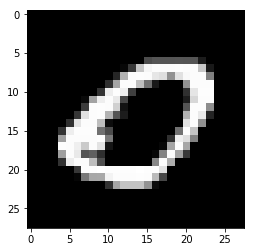

In [8]:
a = mnist.reshape(((5000,28,28)))
plt.imshow(a[0],cmap='gray')
plt.show()

In [67]:
def pltshow(Y, mLabel, fname, xlabel, ylabel, title):
    plt.style.use('ggplot')
    plt.figure(figsize=(8, 6))
    for lab, col in zip(range(5), ('b', 'lightcoral', 'turquoise','violet','gold')):
        plt.scatter(Y[mLabel==(lab+1), 0], Y[mLabel==(lab+1), 1], label=lab, s=20, c=col,alpha=0.8)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc='lower left')
    plt.savefig(fname)
    plt.show()

# PCA

In [3]:
def PCA(mnist):
    # Covariance matrix : [(X-meanx)^(T)*(X-meanx)]/(n-1)
    meanVec = np.mean(mnist, axis=0)
    covar = np.dot(((mnist-meanVec).T),(mnist-meanVec)) / (len(mnist)-1)
    
    #Sort - decrease
    eigVal, eigVec = np.linalg.eig(covar) # eigVal:1*784 ; eigVec:784*784
    eigPair = [(np.abs(eigVal[i]), eigVec[:,i]) for i in range(len(eigVal))] # eigPair=(eigenvalue, eigenvector)
    eigPair.sort(key=lambda x: x[0], reverse=True)
    W = np.hstack((eigPair[0][1].reshape(len(mnist[0]),1), eigPair[1][1].reshape(len(mnist[0]),1)))
    
    # Projection Matrix
    Y = np.dot(mnist, W)
    return Y

C:\Users\Jason\Anaconda3\lib\site-packages\numpy\core\numeric.py:553: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


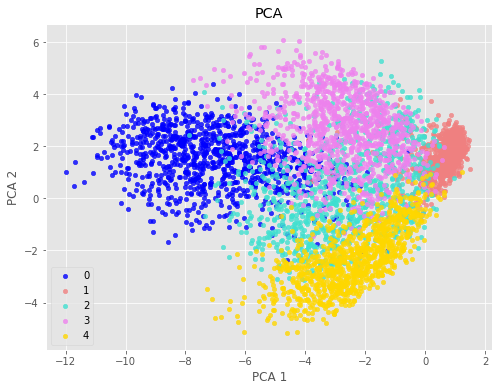

In [66]:
YPCA=PCA(mnist)
pltshow(YPCA, mLabel, 'PCA.png', 'PCA 1', 'PCA 2','PCA')

# LDA

In [53]:
def LDA(mnist):
    # mean vector for each class
    meanVector = []
    for cl in range(5):
        meanVector.append(np.mean(mnist[mLabel==(cl+1)], axis=0))
    
    # meanv: (1/n)*sum(xk); k=0-4
    # scatter: sum((X-meanv)*(X-meanv)^(T)) ; scatter matrix for every class
    # within-class scatter: Sw=sum(scatter)
    Sw = np.zeros((len(mnist[0]),len(mnist[0])))
    for cl,mv in zip(range(5), meanVector):
        scatter = np.zeros((len(mnist[0]),len(mnist[0])))
        for row in mnist[mLabel==(cl+1)]:
            row, mv = row.reshape(len(mnist[0]),1), mv.reshape(len(mnist[0]),1)
            scatter += (row-mv).dot((row-mv).T)
        Sw += scatter 
    
    # between-class scatter: Sb=sum(N*(meanv-overallmean)*(meanv-overallmean)^(T))
    overallM = np.mean(mnist, axis=0)
    SB = np.zeros((len(mnist[0]),len(mnist[0])))
    for i,meanVec in enumerate(meanVector):  
        n = mnist[mLabel==i+1,:].shape[0]
        meanVec = meanVec.reshape(len(mnist[0]),1) # make column vector
        overallM = overallM.reshape(len(mnist[0]),1) # make column vector
        SB += n *np.dot((meanVec-overallM),(meanVec-overallM).T)
    
    # linear discriminants Sw^(-1)*SB
    eigVal, eigVec = np.linalg.eig(np.linalg.pinv(Sw).dot(SB))
    
    #Sort - decrease
    # eigPair=(eigenvalue, eigenvector)
    eigPair = [(np.abs(eigVal[i]), eigVec[:,i]) for i in range(len(eigVal))]
    eigPair = sorted(eigPair, key=lambda k: k[0], reverse=True)
    W = np.hstack((eigPair[0][1].reshape(len(mnist[0]),1), eigPair[1][1].reshape(len(mnist[0]),1)))
    
    # Projection Matrix 
    Y = np.dot(mnist, W)
    return Y

C:\Users\Jason\Anaconda3\lib\site-packages\numpy\core\numeric.py:553: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


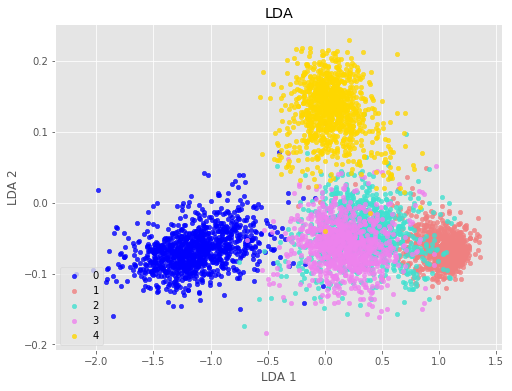

In [68]:
YLDA=LDA(mnist)
pltshow(YLDA, mLabel, 'LDA.png', 'LDA 1', 'LDA 2','LDA')

# T-SNE

In [58]:
def load_data(X_filename, label_filename):
    print('load data.....')
    mnist = np.genfromtxt('mnist_X.csv', delimiter=',') # mnist_X = 5000*784, ML
    mLabel = np.genfromtxt('mnist_label.csv', delimiter=',') # label = 5000*1 label:1-5 = number 0-4 
    return mnist, mLabel

def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P


def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P


def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    # Covariance matrix : [(X-meanx)^(T)*(X-meanx)]/(n-1)
    meanVec = np.mean(X, axis=0)
    covar = np.dot(((X-meanVec).T),(X-meanVec)) / (len(X)-1)
    
    #Sort - decrease
    eigVal, eigVec = np.linalg.eig(covar) # eigVal:1*784 ; eigVec:784*784
    eigPair = [(np.abs(eigVal[i]), eigVec[:,i]) for i in range(len(eigVal))]
    eigPair.sort(key=lambda x: x[0], reverse=True)
    W = np.hstack((eigPair[0][1].reshape(len(X[0]),1), eigPair[1][1].reshape(len(X[0]),1)))
    if no_dims > 2:
        for i in range(2,no_dims):
            W = np.hstack((W, eigPair[i][1].reshape(len(X[0]),1)))
    
    # Projection Matrix
    Y = np.dot(mnist, W)
    return Y


def tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.        # early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y


if __name__ == "__main__":
    print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
    print("Running example on 2,500 MNIST digits...")
    X, labels = load_data('mnist_X.csv', 'mnist_label.csv')
    Y = tsne(X, 2, 50, 20.0)

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on 2,500 MNIST digits...
load data.....
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 5000...
Computing P-values for point 500 of 5000...
Computing P-values for point 1000 of 5000...
Computing P-values for point 1500 of 5000...
Computing P-values for point 2000 of 5000...
Computing P-values for point 2500 of 5000...
Computing P-values for point 3000 of 5000...
Computing P-values for point 3500 of 5000...
Computing P-values for point 4000 of 5000...
Computing P-values for point 4500 of 5000...
Mean value of sigma: 1.799864
Iteration 10: error is 26.648501
Iteration 20: error is 25.602317
Iteration 30: error is 21.927856
Iteration 40: error is 20.017293
Iteration 50: error is 19.120047
Iteration 60: error is 18.621300
Iteration 70: error is 18.386179
Iteration 80: error is 18.274495
Iteration 90: error is 18.156056
Iteration 100: error is 18.

NameError: name 'pylab' is not defined

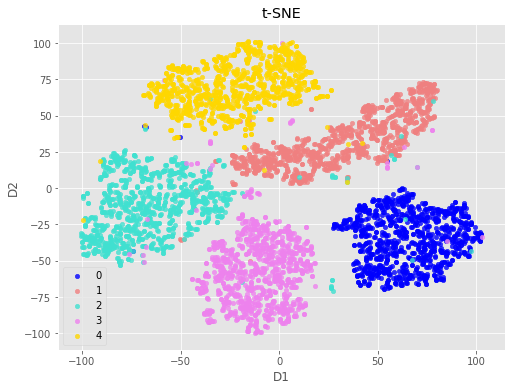

In [64]:
pltshow(Y, mLabel, 't-SNE.png','D1','D2','t-SNE')

# Symmetric SNE

In [69]:
def load_data(X_filename, label_filename):
    print('load data.....')
    mnist = np.genfromtxt('mnist_X.csv', delimiter=',') # mnist_X = 5000*784, ML
    mLabel = np.genfromtxt('mnist_label.csv', delimiter=',') # label = 5000*1 label:1-5 = number 0-4 
    return mnist, mLabel

def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P


def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P


def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    # Covariance matrix : [(X-meanx)^(T)*(X-meanx)]/(n-1)
    meanVec = np.mean(X, axis=0)
    covar = np.dot(((X-meanVec).T),(X-meanVec)) / (len(X)-1)
    
    #Sort - decrease
    eigVal, eigVec = np.linalg.eig(covar) # eigVal:1*784 ; eigVec:784*784
    eigPair = [(np.abs(eigVal[i]), eigVec[:,i]) for i in range(len(eigVal))]
    eigPair.sort(key=lambda x: x[0], reverse=True)
    W = np.hstack((eigPair[0][1].reshape(len(X[0]),1), eigPair[1][1].reshape(len(X[0]),1)))
    if no_dims > 2:
        for i in range(2,no_dims):
            W = np.hstack((W, eigPair[i][1].reshape(len(X[0]),1)))
    
    # Projection Matrix
    Y = np.dot(X, W)
    return Y


def Ssne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.        # early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T) #Y = yi-yj; ||yi-yj||^(2)= np.dot(Y, Y.T)
        num = np.exp(-np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y


if __name__ == "__main__":
    print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
    print("Running example on 2,500 MNIST digits...")
    X, labels = load_data('mnist_X.csv', 'mnist_label.csv')
    YSSNE = Ssne(X, 2, 50, 20.0)

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on 2,500 MNIST digits...
load data.....
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 5000...
Computing P-values for point 500 of 5000...
Computing P-values for point 1000 of 5000...
Computing P-values for point 1500 of 5000...
Computing P-values for point 2000 of 5000...
Computing P-values for point 2500 of 5000...
Computing P-values for point 3000 of 5000...
Computing P-values for point 3500 of 5000...
Computing P-values for point 4000 of 5000...
Computing P-values for point 4500 of 5000...
Mean value of sigma: 1.799864
Iteration 10: error is 30.828025
Iteration 20: error is 27.599329
Iteration 30: error is 24.007919
Iteration 40: error is 22.543088
Iteration 50: error is 21.762576
Iteration 60: error is 21.360995
Iteration 70: error is 21.178172
Iteration 80: error is 20.982247
Iteration 90: error is 20.810189
Iteration 100: error is 20.

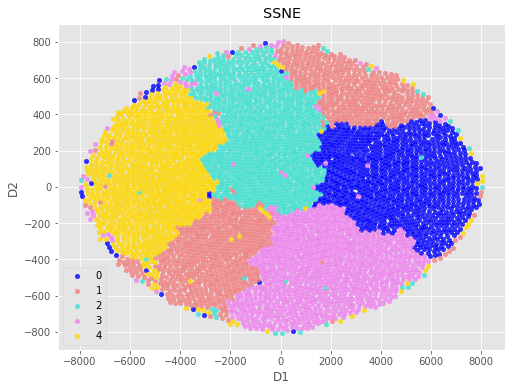

In [70]:
pltshow(YSSNE, mLabel, 'SSNE.png','D1','D2','SSNE')

# Eigenface

In [1]:
import numpy as np
from PIL import Image,ImageOps
from copy import deepcopy
from matplotlib import pyplot as plt
%matplotlib inline

# Read Data

In [2]:
pgmf = open('./att_faces/s1/1.pgm', 'rb')
for i in range(3):
    a = pgmf.readline()
    print(a)

b'P5\n'
b'92 112\n'
b'255\n'


In [3]:
var = 1
directoryName=[]
while var<=40:
    directoryName.append('s'+str(var))
    var+=1

var2 = 1
filename=[]
while var2<=10:
    filename.append(str(var2)+".pgm")
    var2+=1
    
im = Image.open("./att_faces/"+directoryName[0]+"/"+filename[0])
img = np.asarray(im)
img = img.reshape(img.shape[0]*img.shape[1],1)
orimg = deepcopy(img)

for diname in range(40):
    for fname in range(10):
        im = Image.open("./att_faces/"+directoryName[diname]+"/"+filename[fname])
        img = np.asarray(im)
        img = img.reshape(img.shape[0]*img.shape[1],1)
        orimg = np.hstack((orimg,img))

orimg = np.delete(orimg,0,1)
orimg.shape

(10304, 400)

# PCA

In [7]:
def pca(X=np.array([]), no_dims=25):
    # Covariance matrix : [(X-meanx)^(T)*(X-meanx)]/(n-1)
    meanVec = np.mean(X, axis=0)
    covar = np.dot(((X-meanVec).T),(X-meanVec)) / (len(X)-1)
    
    #Sort - decrease
    eigVal, eigVec = np.linalg.eig(covar) # eigVal:1*784 ; eigVec:784*784
    eigPair = [(np.abs(eigVal[i]), eigVec[:,i]) for i in range(len(eigVal))]
    eigPair.sort(key=lambda x: x[0], reverse=True)
    W = np.hstack((eigPair[0][1].reshape(len(X[0]),1), eigPair[1][1].reshape(len(X[0]),1)))
    if no_dims > 2:
        for i in range(2,no_dims):
            W = np.hstack((W, eigPair[i][1].reshape(len(X[0]),1)))
    
    # Projection Matrix
    Y = np.dot(X-meanVec, W)
    return Y

X = pca(orimg,25)
X /= np.linalg.norm(X,axis=0)
print(X.shape)
print(X)

(10304, 25)
[[-0.00837344 -0.01248618  0.01881755 ... -0.01048953 -0.00271995
  -0.00518574]
 [-0.00839009 -0.01243664  0.01883255 ... -0.00974882 -0.00197758
  -0.0057063 ]
 [-0.00827368 -0.01246577  0.01877995 ... -0.01037806 -0.0025246
  -0.0063196 ]
 ...
 [-0.01285105 -0.00166376 -0.00997099 ... -0.00242194 -0.01134842
   0.00122039]
 [-0.01305508 -0.00161541 -0.00836337 ... -0.00460115 -0.00925658
   0.0052217 ]
 [-0.01328849 -0.00292062 -0.00794709 ...  0.00146082 -0.00948866
   0.00590528]]


# eigenface

In [8]:
A = X.T
A = A.reshape(((25,112,92)))

iteration=1
for i in range(25):
    fileN = 'eigenface{:s}.png'.format(str(iteration))
    plt.imsave(fileN,A[i],cmap='gray')
    iteration+=1

# reconstruction

In [9]:
#mean = 10304*1
mean = np.mean(orimg, axis=1).reshape((10304,1))

#parameter: weight 400*25
weight = (np.dot((orimg-mean).T,X))

In [10]:
var3 = 1
fName=[]
while var3<=10:
    fName.append('Reconstrction_'+str(var3)+'.png')
    var3+=1
    
var4 = 1
frawName=[]
while var4<=10:
    frawName.append('RAW_'+str(var4)+'.png')
    var4+=1

In [11]:
orimg = orimg.T
for i in range(10):   
    #restrim = 400*25
    reconim = mean.T+np.dot(weight[i*10],X.T)
    im = reconim.reshape((112,92))
    plt.imsave(fName[i],im, cmap='gray')
    rawim = orimg[i*10].reshape((112,92))
    plt.imsave(frawName[i],rawim, cmap='gray')
    
mmean = mean.reshape((112,92))
plt.imsave("mean.png",mmean, cmap='gray')